In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### PDF 문서 검색 Retrieval Chain 생성

In [2]:
from rag.pdf import PDFRetrievalChain


pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()           # PDF 문서를 로드

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

### State 정의

`State`: Graph 의 노드와 노드들을 끼리 공유하는 상태를 정의합니다.
<br>

State에 관련성(relevance) 체크 결과를 추가합니다.

In [3]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):               
    question: Annotated[str, 'question']            # 질문
    context: Annotated[str, 'context']              # 문서의 검색 결과
    answer: Annotated[str, 'Answer']                # 답변
    messages: Annotated[list, add_messages ]        # 메시지
    relevance: Annotated[str, 'Relevance']          # 관련성

### 노드 정의

`Nodes`: 각 단계를 처리하는 노드입니다. Python 함수로 만들게 되고 함수의 입력과 출력이 상태(State) 값입니다. <br>

`State` 를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 State를 반환합니다.

In [4]:
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs

In [5]:
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_openai import ChatOpenAI

In [6]:
def retrieve_document(state: GraphState) -> GraphState:             # 문서 검색 노드 

    latest_question = state['question']                             # state 에서 질문(question)을 가져온다.

    retrieve_docs = pdf_retriever.invoke(latest_question)           # pdf_retriever를 사용해서 문서 검색하여 관련성 있는 문서를 찾습니다.
    retrieve_docs = format_docs(retrieve_docs)                      # 검색된 문서를 모두 문자열로 변경 (프롬프트의 입력이 된다)
    
    return {'context': retrieve_docs}                               

In [7]:
def llm_answer(state: GraphState) -> GraphState:
    
    latest_question = state['question']                             # state 에서 질문(question)을 가져온다.
    context = state['context']                                      # state 에서 검색된 문서의 내용(context)을 가져온다.

    response = pdf_chain.invoke(                                    # pdf_chain을 호출해서 대답을 만듭니다.
        {
            'question': latest_question,                            # 질문      
            'context': context,                                     # 검색된 문서의 내용
            'chat_history': messages_to_history(state['messages'])  
        }
    )


    return {                                                       
        'answer': response,                                                 # 생성된 답변을 answer에 저장
        'messages': [('user', latest_question), ('assistant', response)]    # user의 질문과 생성된 답변을 messages에 저장
    }

In [8]:
def relevance_check(state: GraphState) -> GraphState:                       # 관련성 평가 노드
    
    question_retrival_relevat = GroundednessChecker(                        # 관련성 평가기를 생성. 
        llm = ChatOpenAI(api_key=key, model_name='gpt-4o-mini'), 
        target='question-retrieval'                                         # 검색된 문서와 질문을 관성성 평가한다.검색된 문서가 질문에 답변하기 위한 내용이 포함되어 있는지 체크하는 평가기.
    ).create()                                                              

    response = question_retrival_relevat.invoke(                            # 관련성 체크 실행 (yes or no)
        {'question': state['question'], 'context': state['context']}
    )

    return {"relevance": response.score}

In [10]:
def is_relevant(state: GraphState) -> GraphState:
    
    if state['relevance']=='yes':
        return 'relevant'
    else:
        return 'not relevant'

In [11]:
from langchain_teddynote.tools.tavily import TavilySearch

def web_search(state: GraphState) -> GraphState:

    tavily_tool = TavilySearch()                # 검색 도구 생성
    search_query = state['question']

    search_result = tavily_tool.search(
        query=search_query,                     # 검색 쿼리
        topic='general',                        # 일반 주제
        max_results=1,                          # 최대 검색 결과
        format_output=True,                     # 결과 포맷팅
    )
    
    
    return {'context': search_result}

### 그래프 정의

`Edges`: 현재 State를 기반으로 다음에 실행할 Node를 결정하는 Python 함수.<br>

일반 엣지, 조건부 엣지 등이 있습니다.

In [12]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

In [13]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [14]:
######### 2. 노드 정의  #########

# 노드 이름, 함수 이름을 넣으서 노트를 추가
workflow.add_node('retrieve', retrieve_document)        # 문서 검색 노드
workflow.add_node('llm_answer', llm_answer)             # 답변 생성 노드
workflow.add_node("relevance_check", relevance_check)   # 관련성 체크 노드 추가

workflow.add_node('web_search', web_search)             # Web Search 노드 추가

In [15]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_edge('retrieve', 'relevance_check')        # 검색(retrieve) 에서 관련성 체크

workflow.add_conditional_edges(                         # 조건부 엣지
    'relevance_check',                                  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달
    is_relevant,                                        # 분기 함수(yse: relevant, no: not relevant)
    {
        'relevant': 'llm_answer',                       # 관련성이 있으면 답변을 생성합니다. llm_answer 실행
        'not relevant': 'web_search',                   # 관련성이 없으면 다시 검색합니다.   retrieve 실행
    },
)

workflow.add_edge("web_search", "llm_answer")           # 웹 검색(web_search) 에서 답변(llm_answer)
workflow.add_edge('llm_answer', END)                    # 답변(llm_answer) 에서 종료(END)

In [16]:
######### 4. 그래프 진입점  #########

workflow.set_entry_point('retrieve')

In [17]:
######### 5. 체크 포인터 설정  #########

memory = MemorySaver()

In [18]:
######### 6. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

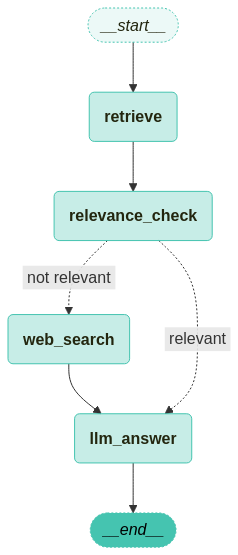

In [19]:
visualize_graph(app)

### 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 정보를 전달.

    - `recursion_limit`: 그래프 실행 시 노드 반복의 횟수를 설정.
    - `thread_id`: 대화 세션을 구분하는 데 사용. 

<br>

- `inputs`: 그래프 실행 시 필요한 입력정보를 전달.

In [20]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

In [21]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='2024년 노벨 문학상 수상자는')

i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1

    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        
        if state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['context']}")
            print('------------------------------')
            print()
        elif state_key == 'llm_answer':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['answer']}")
            print('------------------------------')
            print()
        elif state_key == 'relevance_check':
            print('------------------------------')
            print(f"🔄 [Node] 관련성 평가 노드 🔄")
            print(f"{state_value['relevance']}")
            print('------------------------------')
            print()
        elif state_key == 'web_search':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['context']}")
            print('------------------------------')
            print()

        # print(f"state_value: \n {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : retrieve
------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>CES 2024
이번 전시에는 500곳 이상의 한국기업 참가 예정
기간 장소 홈페이지
2024.1.9~12 미국, 라스베가스 https://www.ces.tech/
- 머신러닝 및 응용에 관한 국제 컨퍼런스(AIMLA 2024)는
인공지능 및 머신러닝의 이론, 방법론 및 실용적 접근에 관한
지식과 최신 연구 결과 공유
- 이론 및 실무 측면에서 인공지능, 기계학습의 주요 분야를
논의하고, 학계, 산업계의 연구자와 실무자들에게 해당 분
AIMLA 2024
야의 최첨단 개발 소식 공유
기간 장소 홈페이지</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>22</page></document>
<document><content>n 참가국들은 튜링상을 수상한 AI 학자인 요슈아 벤지오 교수가 주도하는 ‘과학의 현황(State of
the Science)’ 보고서 작성에도 합의했으며, 보고서를 통해 첨단 AI의 위험과 가능성에 관한
기존 연구를 과학적으로 평가하고 향후 AI 안전 연구를 위한 우선순위를 제시할 계획
n 한국은 영국 정부와 6개월 뒤에 온라인으로 AI 미니 정상회의를 공동 개최하기로 합의했으며,
프랑스 정부와는 1년 후 대면 정상회의를 개최할 예정</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>6</page></document>
<document><content>12
2023년 월호</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></document>
<document><content>£AI 기술 중 머신러

In [22]:
def invoke_graph_(graph=app, inputs=inputs, config=config):
    for chunk in app.stream(inputs, config=config, stream_mode="updates"):
        print(f"==" * 50)
        
        for state_key, state_value in chunk.items():      
            if state_key == 'retrieve':
                print('------------------------------')
                print(f"🔄 [Node] 문서 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
            elif state_key == 'llm_answer':
                print('------------------------------')
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                print(f"{state_value['answer']}")
                print('------------------------------')
            elif state_key == 'relevance_check':
                print('------------------------------')
                print(f"🔄 [Node] 관련성 평가 노드 🔄")
                print(f"{state_value['relevance']}")
                print('------------------------------')
            elif state_key == 'web_search':
                print('------------------------------')
                print(f"🔄 [Node] 웹 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
            
        print(f"==" * 50)
        print()

In [23]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='2024년 노벨 문학상 수상자는')

invoke_graph_(graph=app, inputs=inputs, config=config)

------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>CES 2024
이번 전시에는 500곳 이상의 한국기업 참가 예정
기간 장소 홈페이지
2024.1.9~12 미국, 라스베가스 https://www.ces.tech/
- 머신러닝 및 응용에 관한 국제 컨퍼런스(AIMLA 2024)는
인공지능 및 머신러닝의 이론, 방법론 및 실용적 접근에 관한
지식과 최신 연구 결과 공유
- 이론 및 실무 측면에서 인공지능, 기계학습의 주요 분야를
논의하고, 학계, 산업계의 연구자와 실무자들에게 해당 분
AIMLA 2024
야의 최첨단 개발 소식 공유
기간 장소 홈페이지</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>22</page></document>
<document><content>n 참가국들은 튜링상을 수상한 AI 학자인 요슈아 벤지오 교수가 주도하는 ‘과학의 현황(State of
the Science)’ 보고서 작성에도 합의했으며, 보고서를 통해 첨단 AI의 위험과 가능성에 관한
기존 연구를 과학적으로 평가하고 향후 AI 안전 연구를 위한 우선순위를 제시할 계획
n 한국은 영국 정부와 6개월 뒤에 온라인으로 AI 미니 정상회의를 공동 개최하기로 합의했으며,
프랑스 정부와는 1년 후 대면 정상회의를 개최할 예정</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>6</page></document>
<document><content>12
2023년 월호</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></document>
<document><content>£AI 기술 중 머신러닝, 텐서플로우, 딥러닝의 임금 프리미엄이 높게 평가
n 옥스퍼드 인터넷 연구소(Oxford Internet 

In [24]:
import sys
import time

def stream_graph_(graph=app, inputs=inputs, config=config):
    for chunk in app.stream(inputs, config=config, stream_mode="updates"):
        print(f"==" * 50)
        
        for state_key, state_value in chunk.items():      
            if state_key == 'retrieve':
                print('------------------------------')
                print(f"🔄 [Node] 문서 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
            elif state_key == 'llm_answer':
                print('------------------------------')
                print(f"🔄 [Node] 답변 생성 노드 🔄")
                
                for char in state_value['answer']:
                    sys.stdout.write(char)
                    sys.stdout.flush()
                    time.sleep(0.01)

                print('------------------------------')
            elif state_key == 'relevance_check':
                print('------------------------------')
                print(f"🔄 [Node] 관련성 평가 노드 🔄")
                print(f"{state_value['relevance']}")
                print('------------------------------')

            elif state_key == 'web_search':
                print('------------------------------')
                print(f"🔄 [Node] 웹 검색 노드 🔄")
                print(f"{state_value['context']}")
                print('------------------------------')
                
        print(f"==" * 50)
        print()

In [25]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

# 질문
inputs = GraphState(question='2024년 노벨 문학상 수상자는')

stream_graph_(graph=app, inputs=inputs, config=config)

------------------------------
🔄 [Node] 문서 검색 노드 🔄
<document><content>CES 2024
이번 전시에는 500곳 이상의 한국기업 참가 예정
기간 장소 홈페이지
2024.1.9~12 미국, 라스베가스 https://www.ces.tech/
- 머신러닝 및 응용에 관한 국제 컨퍼런스(AIMLA 2024)는
인공지능 및 머신러닝의 이론, 방법론 및 실용적 접근에 관한
지식과 최신 연구 결과 공유
- 이론 및 실무 측면에서 인공지능, 기계학습의 주요 분야를
논의하고, 학계, 산업계의 연구자와 실무자들에게 해당 분
AIMLA 2024
야의 최첨단 개발 소식 공유
기간 장소 홈페이지</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>22</page></document>
<document><content>n 참가국들은 튜링상을 수상한 AI 학자인 요슈아 벤지오 교수가 주도하는 ‘과학의 현황(State of
the Science)’ 보고서 작성에도 합의했으며, 보고서를 통해 첨단 AI의 위험과 가능성에 관한
기존 연구를 과학적으로 평가하고 향후 AI 안전 연구를 위한 우선순위를 제시할 계획
n 한국은 영국 정부와 6개월 뒤에 온라인으로 AI 미니 정상회의를 공동 개최하기로 합의했으며,
프랑스 정부와는 1년 후 대면 정상회의를 개최할 예정</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>6</page></document>
<document><content>12
2023년 월호</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></document>
<document><content>£AI 기술 중 머신러닝, 텐서플로우, 딥러닝의 임금 프리미엄이 높게 평가
n 옥스퍼드 인터넷 연구소(Oxford Internet 